# Phaedrus text analysis and character/topic mapping

taken from: http://www.gutenberg.org/files/1636/1636-h/1636-h.htm

In [1]:
import numpy as np
from datascience import *
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.lines as lines
%matplotlib inline
import string
import re


Read in the table and index by row number

In [2]:
phaedrus = Table.read_table('Phaedro.txt', names = ['line'])
phaedrus.append_column('line #', np.arange(1,phaedrus.num_rows+1))


Create helper functions that separate the speaker from the quote and add them to the table

In [3]:
def name_separator(line):
    name = line[:8]
    if (name == 'PHAEDRUS') or (name == 'SOCRATES'):
        return name
    else:
        return 'no speaker'

def line_separator(line):
    name = line[:8]
    if (name == 'PHAEDRUS') or (name == 'SOCRATES'):
        return line [10:]
    else:
        return line

phaedrus.append_column('speaker', phaedrus.apply(name_separator, 'line'))
phaedrus.append_column('quote', phaedrus.apply(line_separator, 'line'))
phaedrus = phaedrus.drop('line')
phaedrus

line #,speaker,quote
1,PHAEDRUS,Let us talk.
2,SOCRATES,Shall we discuss the rules of writing and speech as we w ...
3,PHAEDRUS,Very good.
4,SOCRATES,In good speaking should not the mind of the speaker know ...
5,PHAEDRUS,"And yet, Socrates, I have heard that he who would be an ..."
6,SOCRATES,The words of the wise are not to be set aside; for there ...
7,PHAEDRUS,Very true.
8,SOCRATES,Let us put the matter thus:—Suppose that I persuaded you ...
9,PHAEDRUS,That would be ridiculous.
10,SOCRATES,"There is something more ridiculous coming:—Suppose, furt ..."


Interactive widget that can give the most popular words of a certain character

In [4]:
def word_freq(speaker, table):
    spkr_table = table.where(table['speaker'] == speaker.upper())
    dict = {}
    for line in spkr_table['quote']:
        line = line.split(' ')
        for word in line:
            word = word.lower()
            exclude = set(string.punctuation)
            word = ''.join(char for char in word if char not in exclude)
            if word not in dict:
                dict[word] = 1
            else:
                dict[word] += 1
    speaker_frequencies = Table().with_columns(['word', dict.keys(), 'frequency', dict.values()])
    speaker_frequencies = speaker_frequencies.sort('frequency', descending = True)
    return speaker_frequencies

interact(word_freq, speaker=['Phaedrus', 'Socrates'], table = fixed(phaedrus))

word,frequency
the,37
that,31
you,27
and,26
i,26
of,26
is,24
in,20
to,20
he,16


<function __main__.word_freq>

Calculating how many words Socrates and Phaedrus say

In [5]:
soc_total = np.sum(word_freq('Socrates', phaedrus)['frequency'])
pha_total = np.sum(word_freq('Phaedrus', phaedrus)['frequency'])
print('Socrates said a total of', soc_total, 'words.')
print('Phaedrus said a total of', pha_total, 'words.')


Socrates said a total of 5004 words.
Phaedrus said a total of 905 words.


## Visualizing character arcs
The next cell defines the function that creates the visualization

In [6]:
def visualize(table, comparison, Words = False, Compare = 'Speakers', Speaker = ['Phaedrus', 'Socrates'], Normed = False):
    """
    TABLE: A table where each row is a line with a line #, a speaker, and a quote
    COMPARISON: 
        if "line": this function graphs counts for each line 
        if "cumulative": this function graphs counts cumulatively over each line
    WORDS: A string of word(s). If more than one word is entered, words should be separated by a space
    COMPARE: 
        if "Speakers": this function graphs two plots, and each plot represents a unique speaker
        if "Words": this function graphs multiple plots, and each plot represents a unique word
    SPEAKER: A string that identifies which speaker to analyze (only matters when COMPARE == "Words")
    NORMED: True or False, depending on whether the user wants plots to be normalized (or made relative)
    """
    #create copy of table
    test_table = table.copy()
    
    #define functions to search for words in a line
    def string_searcher(string):
        def actual_search(line):
            return re.findall(string, line)
        return actual_search
    
    #get table of lines for each speaker
    socrat = test_table.where(test_table['speaker'] == 'SOCRATES')
    phaed = test_table.where(test_table['speaker'] == 'PHAEDRUS')

    if Compare == 'Speakers':
        #comparing how many times each speaker says a word/phrase on each line
    
        if not Words:
            #defualt: put all words in a list
            def quote_to_list(array_of_lines):
                new_array_lines = []
                for line, i in zip(array_of_lines, range(len(array_of_lines))):
                    line = line.split(' ')
                    array_words = list(map(lambda word: ''.join(e for e in word if e.isalnum()), line))
                    while '' in array_words:
                        array_words.remove('')
                    new_array_lines.append(array_words)
                return new_array_lines
            socrat['quote'] = quote_to_list(socrat['quote'])
            phaed['quote'] = quote_to_list(phaed['quote'])
                
        else:
            #search for words in each line
            socrat['quote'] = socrat.apply(string_searcher(Words), 'quote')
            phaed['quote'] = phaed.apply(string_searcher(Words), 'quote')
        
        #word analysis
        new_col_socrat = socrat.apply(len, 'quote')   
        new_col_phaed = phaed.apply(len, 'quote')
        
        if comparison == 'line':
            #get number of words in each line for each speaker 
            socrat.append_column('counts', new_col_socrat)
            phaed.append_column('counts', new_col_phaed)
            ylabel = 'counts per line'
        elif comparison == 'cumulative':
            #get cumulative counts over each line for each speaker
            socrat.append_column('counts', np.cumsum(new_col_socrat))
            phaed.append_column('counts', np.cumsum(new_col_phaed))
            ylabel = 'cumulative counts per line'
         
       
        #normalize number of words in each line for each speaker
        if Normed:
            phaed['counts'] = [x/pha_total for x in phaed['counts']]
            socrat['counts'] = [x/soc_total for x in socrat['counts']]
            ylabel = 'relative ' + ylabel

        #plotting
        plt.plot(np.arange(0,196,2), phaed['counts'])
        plt.plot(np.arange(1,197,2), socrat['counts'])
        plt.legend(['Phaedrus', 'Socrates'], loc = 2)
        plt.ylabel(ylabel)
        plt.xlabel('line #')
        
    else: 
        #comaring how many times a speaker says each word on each line
        
        #take out empty strings
        strings = Words.split(' ')
        while '' in strings: 
            strings.remove('')
            
        #get appropriate table
        if Speaker == 'Socrates': 
            spk_tbl = socrat
            total_words = soc_total
        else: 
            spk_tbl = phaed
            total_words = pha_total
                
        #word analysis
        for string in strings:
            #get counts of each word on each line for each speaker
            new_col = list(map(len, spk_tbl.apply(string_searcher(string), 'quote')))
            if comparison == 'cumulative':
                ylabel = 'cumulative counts per line'
                #get cumulative counts for each word
                new_col = np.cumsum(new_col)
            spk_tbl.append_column(string, new_col)
            
        if comparison == 'cumulative':
            ylabel = 'cumulative counts per line'
        else: 
            ylabel = 'counts per line'
            
        #normalize number of words in each line for each speaker
        if Normed:
            for string in strings:
                spk_tbl[string] = [x/total_words for x in spk_tbl[string]]
            ylabel = 'relative ' + ylabel
            
        #plotting
        if test_table.column(0).item(0) == spk_tbl.column(0).item(0):
            lines = np.arange(0,196,2)
        else: 
            lines = np.arange(1,197,2)
        for string in strings:
            plt.plot(lines, spk_tbl[string])
        plt.legend(strings, loc = 2)
        plt.ylabel(ylabel)
        plt.xlabel('line #')

### Interactive word finder for each line
Note: default graph for comparing speakers is the amount of all the words they say.

<function __main__.visualize>

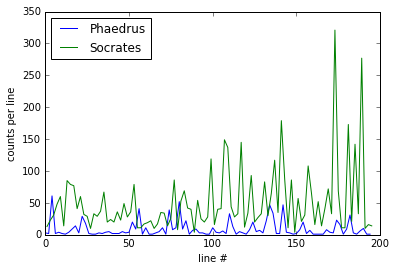

In [7]:
interact(visualize, table = fixed(phaedrus), comparison = fixed('line'), Words = '' , 
         Compare = ['Speakers', 'Words'], 
         Speaker = ['Socrates', 'Phaedrus'], Normed = fixed(False))

### Interactive cumulative word finder 
Note: default graph for comparing speakers is the amount of all the words they say.

<function __main__.visualize>

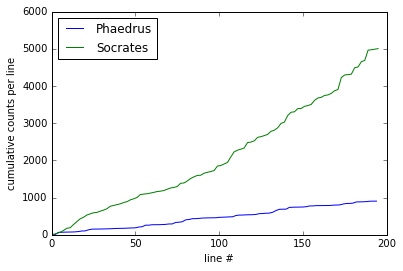

In [8]:
interact(visualize, table = fixed(phaedrus), comparison = fixed('cumulative'), Words = '', 
         Compare = ['Speakers', 'Words'], 
         Speaker = ['Socrates', 'Phaedrus'], Normed = fixed(False) )

## Manually creating word clouds 
(from wordclouds.com)

In [9]:
#Put all text and text from Socrates into two strings, export them in a csv file, and use wordclouds.com to create word clouds

words_array = phaedrus.column('quote')
total_words = ''
for word in words_array:
    total_words += ' '
    total_words += word
    
soc_array = phaedrus.where('speaker', 'SOCRATES').column('quote')
soc_words = ''
for word in soc_array:
    soc_words += ' '
    soc_words += word
    
word_clouds = Table().with_columns([
        'Types', np.array(['Total', 'Socrates']),
        'Texts', np.array([total_words, soc_words])
    ])

word_clouds.to_csv('word_clouds_table.csv')

In [10]:
from IPython.display import Image

### Word cloud of both speakers

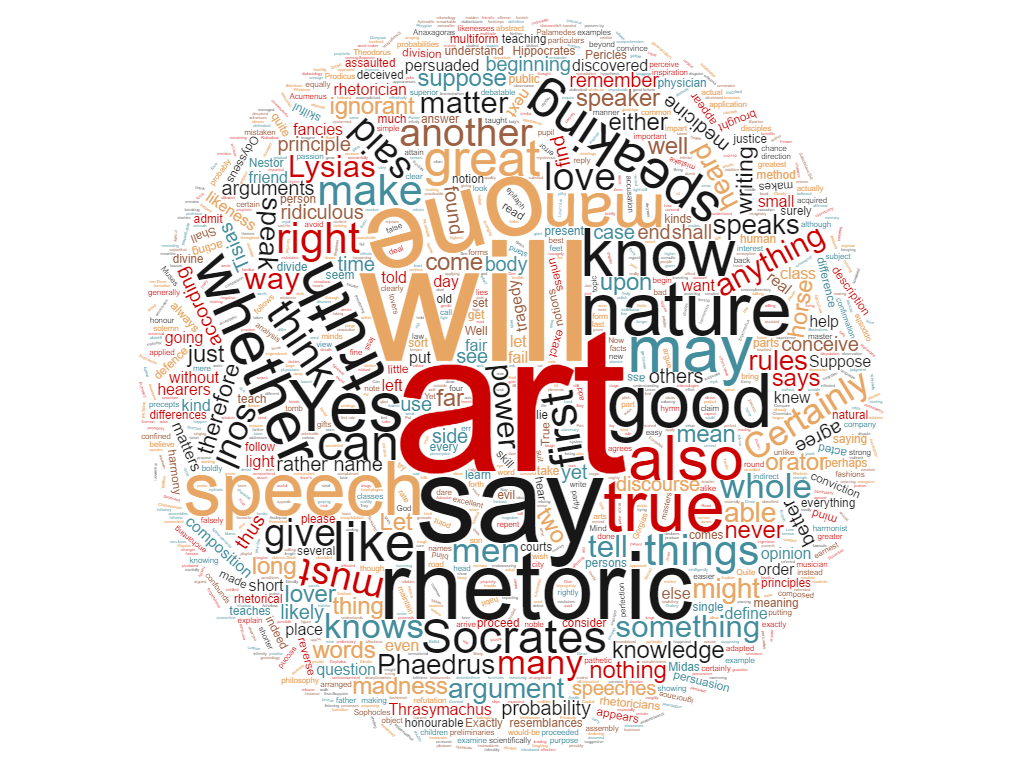

In [11]:
all_words_cloud = Image(filename = 'all_cloud.png')
all_words_cloud

### Word cloud of Socrates

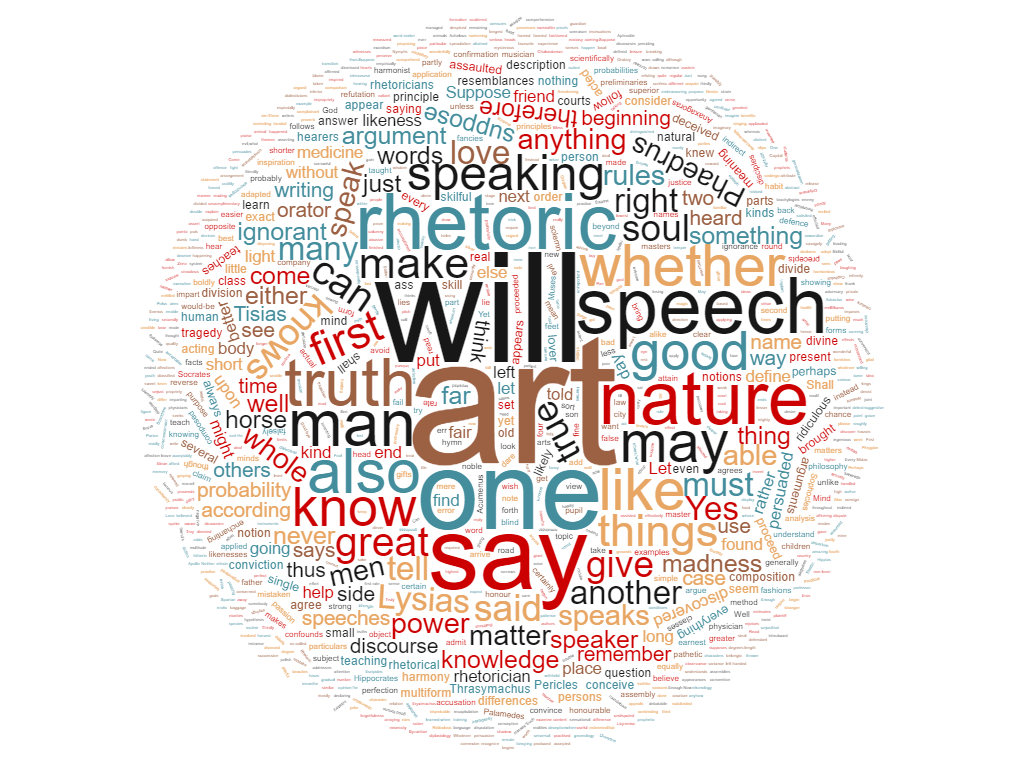

In [12]:
soc_words_cloud = Image(filename = 'soc_cloud.png')
soc_words_cloud